# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1. Business Understanding

" Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. "

Initial Thoughts:
- Not all the users receieve the same offer so a means of determining which offers will be the most effective by demographic wouldbe useful. 
- Will need to distinguish between intentional and 'inadvertant' completions (i.e. where offer not viewed) 
- Might be interesting to examine whether information offers have any effect 
- As mentioned above, certain demographics may be likely to spend without any need for an offer 

Objectives: 

I aim to build a model to predict whether or not a customer will respond to an offer, I will compare two methods:
- Initially I will use a regular test/train split on a multilabel classification solution, with a view from the end of the simulation i.e. using total numbers of completions, total spend etc
- I will also use a time-based test/train split, which calculates features on an ongoing basis. This method will allow me to treat offers receieved as data points, and use a binary classification 
- I will then relate the more effective of the two models back to customer demographic and evaluate the performance 

# 2. Data Understanding 

From description and scheme above, the data comes from a simulation of the offers sent out by starbucks.

Within this section, I aim to understand any obvious relationships within the data that can later be used to either improve my methodology or the understanding of my results

Featuring:
- An initial glance at data, observing structure and simplifying customer ids
- The distributions of customers according to income, age and expenditure, and then the relationships between 
- A summary of 'popularity' by offer i.e. volumes received, viewed and completed 
- A look at customer behaviour regarding offers i.e. interactions with offers received by customer id

***Gather***

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

***Assess***

In [3]:
# Offer ids and meta data on each offer 
print(portfolio)

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
5  229

In [4]:
# Demographic data for each customer - At first glance, null values and unlikely ages evident
print(profile.head())

   age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN


In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


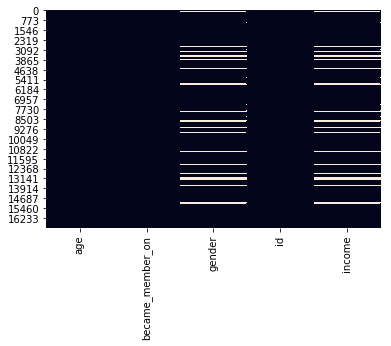

In [6]:
# Looking at profile NaN values, null income and gender values coincide
sns.heatmap(profile.isna(), cbar=False)

In [7]:
# Record of transactions 
# Look at example of customer history
print(transcript[transcript['person'] == transcript['person'].iloc[0]].head(6))

                 event                            person  time  \
0       offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
15561     offer viewed  78afa995795e4d85b5d9ceeca43f5fef     6   
47582      transaction  78afa995795e4d85b5d9ceeca43f5fef   132   
47583  offer completed  78afa995795e4d85b5d9ceeca43f5fef   132   
49502      transaction  78afa995795e4d85b5d9ceeca43f5fef   144   
53176   offer received  78afa995795e4d85b5d9ceeca43f5fef   168   

                                                   value  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
15561   {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
47582                                  {'amount': 19.89}  
47583  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...  
49502                                  {'amount': 17.78}  
53176   {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}  


In [8]:
# First, deal with the inconvenient customer ids
def map_cust(df, ID):
    '''
    In: df- dataframe containng predefined customer id 
        ID- field name of predefined customer id 
        
    Out: df- newly mapped dataframe 
    
    Function provides customer id from dictionary to create new field called cust_id then drops field containing predefined id
    
    '''
    df['cust_id'] = df[ID].apply(lambda x: cust_dict[x]) 
    df = df.drop([ID], axis=1)
    return df

cust_dict =dict((j, i+1) for i,j in enumerate(list(profile.id)))
profile = map_cust(profile, 'id')
transcript = map_cust(transcript, 'person')
print(profile.head())

   age  became_member_on gender    income  cust_id
0  118          20170212   None       NaN        1
1   55          20170715      F  112000.0        2
2  118          20180712   None       NaN        3
3   75          20170509      F  100000.0        4
4  118          20170804   None       NaN        5


In [9]:
# Similarly, create dictionary for portfolio name/id- here can use features of product for informative name
portfolio['name'] = portfolio['difficulty'].apply(str) + '_' + portfolio['duration'].apply(str) + '_' + portfolio['offer_type'].apply(lambda x: x[:4]) + '_' + portfolio['reward'].apply(str)
pfolio_dict = portfolio[['id','name']].set_index('id').to_dict()['name']
pfolio_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': '10_7_bogo_10',
 '4d5c57ea9a6940dd891ad53e9dbe8da0': '10_5_bogo_10',
 '3f207df678b143eea3cee63160fa8bed': '0_4_info_0',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': '5_7_bogo_5',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': '20_10_disc_5',
 '2298d6c36e964ae4a3e7e9706d1fb8c2': '7_7_disc_3',
 'fafdcd668e3743c1bb461111dcafc2a4': '10_10_disc_2',
 '5a8bc65990b245e5a138643cd4eb9837': '0_3_info_0',
 'f19421c1d4aa40978ebb69ca19b0e20d': '5_5_bogo_5',
 '2906b810c7d4411798c6938adc9daaa5': '10_7_disc_2'}

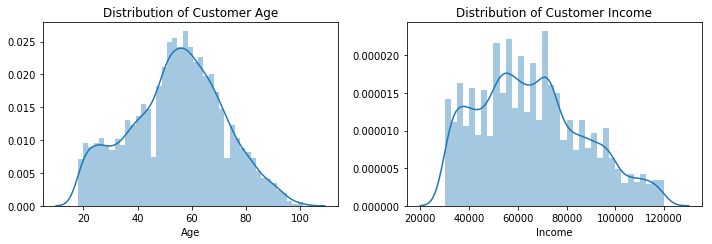

The mean age is 54.4, the mode is 58.0 and the median is 55.0 
The mean income is 65405, the mode is 73000 and the median is 64000 


In [10]:
# Examining the profile dataset in more detail
# Look at distribution of age and income, removing nan values
age_dist = profile[profile['income'].notna()]['age']
inc_dist = profile[profile['income'].notna()]['income']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.5))

sns.distplot(age_dist, ax = ax1)

ax1.set(title = "Distribution of Customer Age", xlabel = 'Age')


sns.distplot(inc_dist, ax= ax2)

ax2.set(title = "Distribution of Customer Income", xlabel = 'Income')

fig.tight_layout()
plt.show()


print('The mean age is {:.1f}, the mode is {:.1f} and the median is {:.1f} '.format(age_dist.mean(), age_dist.mode()[0], age_dist.median()))

print('The mean income is {:.0f}, the mode is {:.0f} and the median is {:.0f} '.format(inc_dist.mean(), inc_dist.mode()[0], inc_dist.median()))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


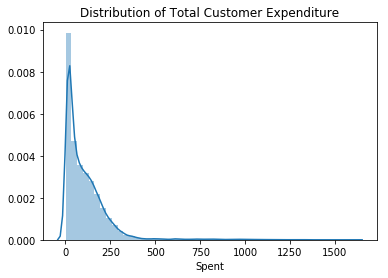

The mean total spend by customer is 107.1, the median is 72.4. The max is 1608.7 


In [11]:
# Also interesting to look into distribution of customer expenditure 

# Take just the transactions from transcript and sum at a customer level 
cust_trans = transcript[transcript['event'] ==  'transaction']
cust_trans['spent'] = cust_trans.value.apply(lambda x: x['amount'])
spent_dist = cust_trans.groupby('cust_id')[['spent']].sum()

sns.distplot(spent_dist)

plt.title("Distribution of Total Customer Expenditure")
plt.xlabel("Spent")
plt.show()

print('The mean total spend by customer is {:.1f}, the median is {:.1f}. The max is {:.1f} '.format(spent_dist['spent'].mean(), spent_dist['spent'].median(), spent_dist['spent'].max()))

*Some surprisingly big spends in dataset, appears that mean is being skewed by these outliers*

<bound method Figure.show of <matplotlib.figure.Figure object at 0x7f404a28ae80>>

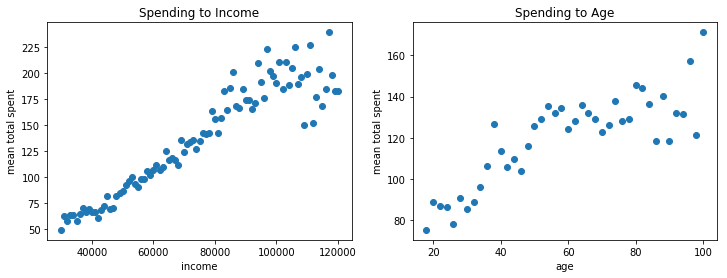

In [12]:
# Also a quick look into whether there are any obvious reasons for a customer spending more 
cust_spent = profile.set_index('cust_id')[['age', 'income']].merge(cust_trans.groupby('cust_id')[['spent']].sum(), left_index=True, right_index=True)

# Place incomes into arbitrary bins and find mean for each
cust_spent['income_bin']= cust_spent['income'].dropna().apply(lambda x: int(x//200) *200)
spent_mean_inc = cust_spent.dropna().groupby('income_bin')[['spent']].mean()

cust_spent['age_bin']= cust_spent.dropna()['age'].apply(lambda x: int(x//2) *2)
spent_mean_age = cust_spent.dropna().groupby('age_bin')[['spent']].mean()

fig, (ax1, ax2 )= plt.subplots(1,2, figsize=(12, 4))

ax1.scatter(spent_mean_inc.index , spent_mean_inc['spent'])
ax1.set(title = 'Spending to Income', xlabel = 'income', ylabel = 'mean total spent')

ax2.scatter(spent_mean_age.index , spent_mean_age['spent'])
ax2.set(title = 'Spending to Age', xlabel = 'age', ylabel = 'mean total spent')
fig.show

*Trend fairly obvious when mean spend used- generally, older customers and those on higher incomes (obviously older customers more likely to be on high incomes) tend to spend more on average*

In [13]:
# Format suitable to split by hue with seaborn 
offers = transcript[transcript['event'] !=  'transaction']
offers['pfolio_id'] = offers['value'].apply(lambda x: pfolio_dict[list(x.values())[0]])
offer_split = offers.groupby(['event', 'pfolio_id'])[['value']].count().reset_index().sort_values(by = ['event', 'value'], ascending = [True, False])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


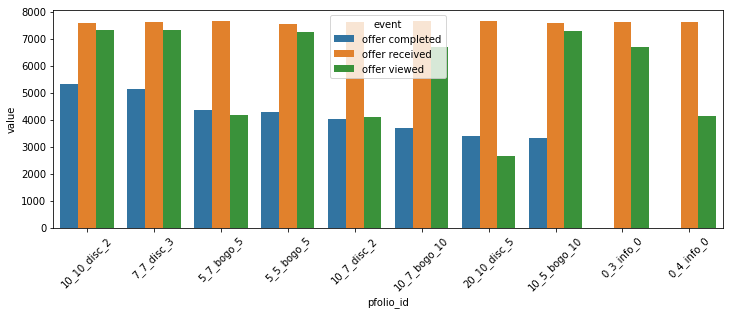

In [14]:
# Plot shows all offers, sorted by offers completed in descending order
fig, ax= plt.subplots( figsize=(12, 4))
ax = sns.barplot(x="pfolio_id", y='value', hue = 'event', data=offer_split)
plt.xticks(rotation=45)
plt.show()

*From bar chart, clear that similar volumes of each type of offer received across the population. Both informational offers clearly have no completions as expected. No obvious reasons for relative popularity at this stage. Note that here, completions are absolute and do not take into account whether intentional or not.*

*(Name is difficulty + duration + type + reward)*

In [15]:
# Summarise offer response by cust
transcript_offers = transcript [transcript['event'] != 'transaction']
transcript_offers['pfolio_id'] = transcript_offers['value'].apply(lambda x: pfolio_dict[list(x.values())[0]])

# Remove informational offers
transcript_offers = transcript_offers[transcript_offers['pfolio_id'].str.contains('info')== False]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Group transcript by customer id showing offers received, completed and viewed 
transcript_grouped = transcript_offers.groupby(['cust_id','event'])['value'].count().unstack().fillna(0)
transcript_grouped = transcript_grouped[['offer received', 'offer viewed', 'offer completed']]

# Calculate proportions by customer id 
transcript_grouped['% viewed'] =  (transcript_grouped['offer viewed']/ transcript_grouped['offer received'] * 100).round(2)
transcript_grouped['% completed'] =  (transcript_grouped['offer completed']/ transcript_grouped['offer received'] * 100).round(2)
transcript_grouped = transcript_grouped.fillna(0)

transcript_grouped.head()

event,offer received,offer viewed,offer completed,% viewed,% completed
cust_id,,,,,
1,5.0,5.0,2.0,100.00,40.0
2,1.0,0.0,1.0,0.00,100.0
3,1.0,1.0,0.0,100.00,0.0
4,3.0,3.0,3.0,100.00,100.0
5,3.0,2.0,0.0,66.67,0.0


In [17]:
# Merge customer transactional behaviour onto the customer profiles
cust_summ = profile.set_index('cust_id').merge(transcript_grouped, left_index = True, right_index = True)
cust_summ['age_bin'] = cust_summ['age'] // 5 * 5
cust_summ['inc_bin'] = cust_summ['income'] // 10000 * 10000
cust_summ.head()

,age,became_member_on,gender,income,offer received,offer viewed,offer completed,% viewed,% completed,age_bin,inc_bin
cust_id,,,,,,,,,,,
1,118,20170212,None,NaN,5.0,5.0,2.0,100.00,40.0,115,NaN
2,55,20170715,F,112000.0,1.0,0.0,1.0,0.00,100.0,55,110000.0
3,118,20180712,None,NaN,1.0,1.0,0.0,100.00,0.0,115,NaN
4,75,20170509,F,100000.0,3.0,3.0,3.0,100.00,100.0,75,100000.0
5,118,20170804,None,NaN,3.0,2.0,0.0,66.67,0.0,115,NaN


In [18]:
def sns_dual_plot(df, x, y1, t1, y2, t2):
    '''
    In: df - Dataframe
        x - Feature from dataframe that will be on x axis 
        y1 - Feature to make up first y axis 
        t1 - Title of first plot
        y2 - Feature to make up second y axis 
        t2 - Title of second plot
    
    Function that takes in a single dataframe and plots two seaborn bar plots within a multi plot using the same y values 
    '''
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4), sharey = True) 
    
    sns.barplot(x= df[x], y = df[y1], ax= ax1)
    ax1.set(title = t1 , xlabel = x, ylabel = y1)
    ax1.tick_params(rotation=45)
    
    sns.barplot(x= df[x], y = df[y2], ax =ax2)
    ax2.set(title = t2 , xlabel = x, ylabel = y2)
    ax2.tick_params(rotation=45)
    
    fig.tight_layout()
    plt.show()

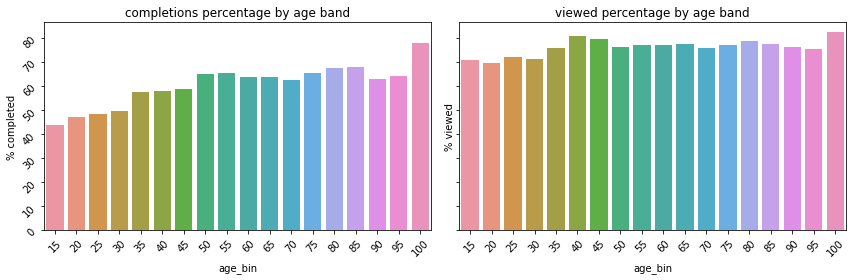

In [19]:
# Summary by age bin
age_group = cust_summ.dropna().groupby('age_bin')[['% completed']].mean()
age_group = age_group.join(cust_summ.dropna().groupby('age_bin')[['% viewed']].mean()).reset_index()

sns_dual_plot(age_group, 'age_bin' ,'% completed','completions percentage by age band', '% viewed', 'viewed percentage by age band')

*Definite trend in older customers completing more offers, less clear in viewing. However, as shown earlier, older customers tend to spend more money so this is to be expected.*

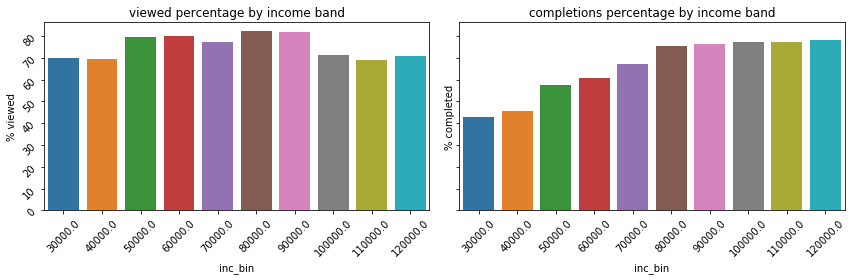

In [20]:
# Summary by income bin
inc_group = cust_summ.dropna().groupby('inc_bin')[['% completed']].mean()
inc_group = inc_group.join(cust_summ.dropna().groupby('inc_bin')[['% viewed']].mean()).reset_index()

sns_dual_plot(inc_group, 'inc_bin' , '% viewed', 'viewed percentage by income band', '% completed','completions percentage by income band')

*Similarly to the age band plot, relationship between offers viewed and income not especially obvious. Meanwhile, customers on a higher salary seem to complete more offers as they tend to spend more.*

# 3. Data Preparation

Here I will prepare the data for modelling.

- Initially I need to determine which completions were intentional, as this is what I will base both models on
- For this purpose I will treat the problem as a binary classification problem i.e. either the customer has responded to an offer or they have not
- For the multilabel classification approach, the customer has successfuly interacted with the offer if at some point during the simulation they have intentionally completed that offer
- For the binary approach, the offer receieved is successful if it is later completed intentionally 
- I will then prepare a basic model for an inidication of data suitability, using only basic features
- I will then further prepare the data for modelling by creating functions for creating the appropriate dataset and relevant features
- This function will be applicable for producing the datasets for both models 

***Determining which completions were intentional***

In [21]:
# By sorting by cust id, pfolio id and time, the assumption can be made that an offer is then viewed and then subsequently completed, the completion is intentional 
successful_offers = transcript_offers.sort_values(by=['cust_id', 'pfolio_id', 'time'])
successful_offers['next_event']= successful_offers['event'].shift(-1)

successful_offers.loc[(successful_offers['event'] == 'offer viewed') & (successful_offers['next_event'] == 'offer completed'), 'intent_comp'] = 1 

# Matrix showing intentionally completed offers for use in binary classification models
# ie customers missing are those who have not intentionally completed an offer 
successful_offers = successful_offers.dropna()[['cust_id', 'pfolio_id', 'intent_comp']].reset_index().drop(['index'], axis = 1)

# Drop duplicates means weighting cannot be applied 
successful_offers_mat = successful_offers.drop_duplicates().groupby(['cust_id', 'pfolio_id'])['pfolio_id'].count().unstack().fillna(0)
successful_offers_mat.head()

pfolio_id,10_10_disc_2,10_5_bogo_10,10_7_bogo_10,10_7_disc_2,20_10_disc_5,5_5_bogo_5,5_7_bogo_5,7_7_disc_3
cust_id,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Count the number of successful completions by customer 
int_comp_cust_summ = successful_offers.groupby('cust_id')[['intent_comp']].count()
cust_summ_upd = cust_summ.merge(int_comp_cust_summ, how='left', right_index=True, left_index=True)
cust_summ_upd['intent_comp'] = cust_summ_upd['intent_comp'].fillna(0)
cust_summ_upd['% int comp'] = cust_summ_upd['intent_comp']/cust_summ_upd['offer received'] * 100

cust_summ_upd.dropna().head()

,age,became_member_on,gender,income,offer received,offer viewed,offer completed,% viewed,% completed,age_bin,inc_bin,intent_comp,% int comp
cust_id,,,,,,,,,,,,,
2,55,20170715,F,112000.0,1.0,0.0,1.0,0.0,100.00,55,110000.0,0.0,0.000000
4,75,20170509,F,100000.0,3.0,3.0,3.0,100.0,100.00,75,100000.0,2.0,66.666667
6,68,20180426,M,70000.0,3.0,3.0,2.0,100.0,66.67,65,70000.0,2.0,66.666667
9,65,20180209,M,53000.0,6.0,6.0,5.0,100.0,83.33,65,50000.0,5.0,83.333333
13,58,20171111,M,51000.0,2.0,2.0,1.0,100.0,50.00,55,50000.0,1.0,50.000000


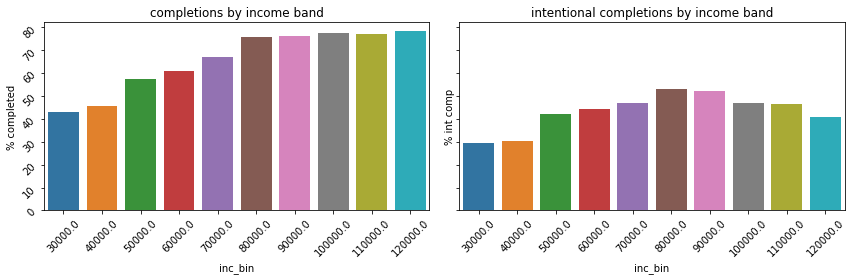

In [23]:
# Looking at how completion volumes compare to intentional completions regarding income bracket
inc_group_upd = inc_group.merge(cust_summ_upd.dropna().groupby('inc_bin')[['% int comp']].mean(), on = 'inc_bin')

sns_dual_plot(inc_group_upd, 'inc_bin' ,'% completed','completions by income band', '% int comp', 'intentional completions by income band')

*Interestingly, just accounting for intentional completions changes the shape of the distribution*

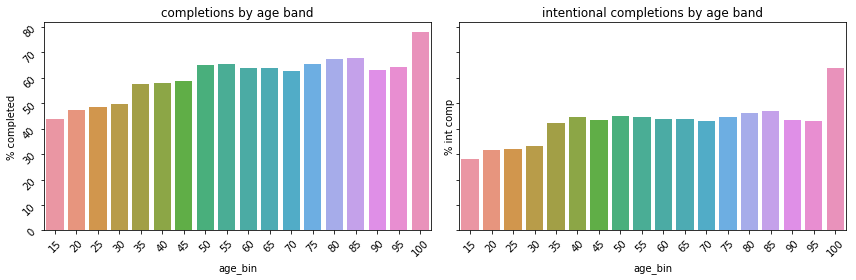

In [24]:
# Also looking at how completions compare to intentioanl completions regarding age
age_group_upd = age_group.merge(cust_summ_upd.dropna().groupby('age_bin')[['% int comp']].mean(), on = 'age_bin')

sns_dual_plot(age_group_upd, 'age_bin' ,'% completed','completions by age band', '% int comp', 'intentional completions by age band')

*Meanwhile, regarding age bracket, the shape is essentially retained while the volumes are reduced*

***Preparing the data for a preliminary model, using only features from the profile dataset plus spending***

In [25]:
#Convert became_member on to date format 
profile_mod = profile.copy()
profile_mod['date_joined'] = profile_mod['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d') )

#Assume most recent date date of collection - maybe change 
date_collected = pd.to_datetime(profile_mod['date_joined'].max())

# Calculate no. days as member from date joined i.e. time with = time since joining at start of simulation 
profile_mod['time_with'] = profile_mod['date_joined'].apply(lambda x : (date_collected - x).days)
profile_mod = profile_mod.drop(['became_member_on', 'date_joined'], axis = 1)

# Add customer total spend 
profile_mod = profile_mod.set_index('cust_id').merge(cust_spent[['spent']], right_index = True, left_index =True, how ='left')

#profile = profile.dropna()
profile_mod = profile_mod.merge(pd.get_dummies(profile_mod[['gender']]), right_index = True, left_index =True)

# Still have all customers at this point 
profile_mod.head()

,age,gender,income,time_with,spent,gender_F,gender_M,gender_O
cust_id,,,,,,,,
1,118,None,NaN,529,20.40,0,0,0
2,55,F,112000.0,376,77.01,1,0,0
3,118,None,NaN,14,14.30,0,0,0
4,75,F,100000.0,443,159.27,1,0,0
5,118,None,NaN,356,4.65,0,0,0


In [26]:
# Keep X & y as single dataframe for now to ensure shape retained
cust_mod_df = profile_mod.merge(successful_offers_mat, how='left', left_index =True, right_index=True).drop(['gender'], axis = 1)

# drop nan incomes
cust_mod_df = cust_mod_df[cust_mod_df['income'].notna()].fillna(0)

cust_mod_df.head()

,age,income,time_with,spent,gender_F,gender_M,gender_O,10_10_disc_2,10_5_bogo_10,10_7_bogo_10,10_7_disc_2,20_10_disc_5,5_5_bogo_5,5_7_bogo_5,7_7_disc_3
cust_id,,,,,,,,,,,,,,,
2,55,112000.0,376,77.01,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75,100000.0,443,159.27,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,68,70000.0,91,57.73,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,65,53000.0,167,36.43,0,1,0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
13,58,51000.0,257,15.62,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Clean up profile for non null population

# 14,825 entries
profile_clean = profile[profile['income'].notna()]
profile_clean['date_joined'] = profile_clean['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d') )
date_collected = pd.to_datetime(profile_clean['date_joined'].max())

# Calculate no. days as member from date joined i.e. time with = time since joining at start of simulation 
profile_clean['time_with_t0'] = profile_clean['date_joined'].apply(lambda x : (date_collected - x).days)
profile_clean = profile_clean.drop(['became_member_on', 'date_joined'], axis = 1).set_index('cust_id')

profile_clean.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,age,gender,income,time_with_t0
cust_id,,,,
2,55,F,112000.0,376
4,75,F,100000.0,443
6,68,M,70000.0,91
9,65,M,53000.0,167
13,58,M,51000.0,257


In [28]:
# Version of profile using imputation

# 17,000 entries
profile_imp = profile.copy()
profile_imp['date_joined'] = profile_imp['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d') )
date_collected = pd.to_datetime(profile_imp['date_joined'].max())

# Calculate no. days as member from date joined i.e. time with = time since joining at start of simulation 
profile_imp['time_with_t0'] = profile_imp['date_joined'].apply(lambda x : (date_collected - x).days)
profile_imp = profile_imp.drop(['became_member_on', 'date_joined'], axis = 1).set_index('cust_id')

# Imputation (using means from distributions from earlier) :
profile_imp.loc[profile_imp['age'] == 118, ['age', 'gender', 'income']] = age_dist.mean(), 'N', inc_dist.mean()
profile_imp.head()

,age,gender,income,time_with_t0
cust_id,,,,
1,54.393524,N,65404.991568,529
2,55.000000,F,112000.000000,376
3,54.393524,N,65404.991568,14
4,75.000000,F,100000.000000,443
5,54.393524,N,65404.991568,356


In [29]:
# Redo successful offers so completed flag on completion
successful_offers = transcript_offers.sort_values(by=['cust_id', 'pfolio_id', 'time'])
successful_offers.loc[(successful_offers['event'] == 'offer completed') & (successful_offers['event'].shift(1) == 'offer viewed'), 'intent_comp'] = 1 

***Create functions for both 'end view' and time-based splitting***

In [30]:
def target_var_time_split(t1, t2, Bin=True):
    '''
    In: t1 - start of time period of interest
        t2 - end of time period of interest
    
    Out: target_tran_subset - subset of transcript within defined time period
         successful_offers_mat_subset - binary 'user-item' matrix of all customers with intentional completions within time period
         successful_offers_count - sum of intentional completions by customer within time period
    
    Function to generate matrix of intentional completions by product and count by customer, according to time period 
    '''
    target_tran_subset = transcript[(transcript['time'] < t2) & (transcript['time'] >= t1)  ]
    
    successful_offers_subset = successful_offers[(successful_offers['time']  <= t2) & (successful_offers['time'] > t1)].drop([ 'value'], axis =1 ).fillna(0)
    successful_offers_count = successful_offers_subset.groupby('cust_id')[['intent_comp']].sum()

    # Creates matrix of all customer within intentional completions between t1 and t2
    
    # No weighting applied- 1 == intentional completion(s), 0 == no intentional completions 
    if Bin:
        #successful_offers_mat_subset = (successful_offers_mat_subset/successful_offers_mat_subset).fillna(0)
        successful_offers_mat_subset = successful_offers_subset.drop_duplicates().groupby(['cust_id', 'pfolio_id'])['intent_comp'].sum().unstack().fillna(0)
        successful_offers_mat_subset = (successful_offers_mat_subset/successful_offers_mat_subset).fillna(0)
    else:
        successful_offers_mat_subset = successful_offers_subset.groupby(['cust_id', 'pfolio_id'])['intent_comp'].sum().unstack().fillna(0)
    
        
    return target_tran_subset, successful_offers_mat_subset, successful_offers_count

In [31]:
def transactional_time_split(t_subset):
    '''
    In: t_subset - subset of transcript within given time period
    
    Out: cust_trans_summ - dataframe of features derived from transaction in transcript
    
    Derives relevant features from customer transactions:
        - number of transactions
        - average interval 
        - average spend
        - total spend
    
    '''
    t_subset_trans = t_subset[t_subset['event'] == 'transaction']
    t_subset_trans['spent'] = t_subset_trans['value'].apply(lambda x: list(x.values())[0])
    
    t_subset_sorted = t_subset_trans[['cust_id','time', 'spent']].sort_values(by = ['cust_id', 'time'])
    t_subset_sorted['next_time']= t_subset_sorted['time'].shift(-1)

    # Assumes if time next time is below current time, switched to a different customer
    t_subset_sorted.loc[t_subset_sorted['next_time'] >= t_subset_sorted['time'], 'interval'] = t_subset_sorted['next_time'] - t_subset_sorted['time']


    # Take mean of intervals between transactions and mean spend by customer
    cust_trans_summ = t_subset_sorted.groupby('cust_id')[['interval']].mean().merge(t_subset_sorted.groupby('cust_id')[['cust_id']].count(), left_index =True, right_index=True)
    # Calculate total spend
    cust_trans_summ = cust_trans_summ.merge(t_subset_sorted.groupby('cust_id')[['spent']].sum(), left_index=True, right_on='cust_id')
    cust_trans_summ = cust_trans_summ.rename(columns={"interval": "mean_interval", "spent": "total_spend" ,"cust_id": "trans_count"})
    cust_trans_summ['mean_spend'] = cust_trans_summ['total_spend']/cust_trans_summ['trans_count']

    return cust_trans_summ

In [32]:
def offer_time_split(t_subset, successful_offers_count, final):
    '''
    In: t_subset - subset of transcript within given time period
        successful_offers_count - dataframe containing sum of intentional completions by customer
        final - boolean indicator, True if 'endview' methodology used, False if time series
        
    Out: trans_grouped - dataframe containing features derived from offer interactions found in transcript dataframe
    
    Counts up volumes of offer interactions by customer e.g. no. views, no. intentional completions.
    If final is True, the proportions of views and completions are also calculated. This is not done for time series as 
    the offer is often viewed or completed in a seperate time period to when it is received.
    '''

    # Count of offer types by customer
    trans_grouped = t_subset.groupby(['cust_id','event'])['value'].count().unstack().merge(successful_offers_count, right_index=True, left_index=True, how='left').fillna(0)
    
    # Check in case no offers of that type within time period
    for r in ['offer received','offer viewed','offer completed']:
        if r not in trans_grouped.columns:
            trans_grouped[r] = 0
    
    if final:
        trans_grouped['% viewed'] =  (trans_grouped['offer viewed']/ trans_grouped['offer received'])
        trans_grouped['% completed'] =  (trans_grouped['offer completed']/ trans_grouped['offer received'])
        trans_grouped['% int completed'] =  (trans_grouped['intent_comp']/ trans_grouped['offer received'])
        
    # Drop transaction as equivalent to trans_count calculated elsewhere
    trans_grouped = trans_grouped.drop(['transaction'], axis = 1).fillna(0)
    
    return trans_grouped

In [33]:
def gen_xy_set(t1,t2, profile_clean, final = False, Bin = True):
    '''
    In: t1 - start of time period of interest
        t2 - end of time period of interest
        final - boolean indicator, True if 'endview' methodology used, False if time series
    
    Out: xy_set - dataframe containing both input and target variables for each customer
    
    Function derives all features required for modelling and merges into a dataframe also containing the target variables.
    In addition to the features derived in the sub function, the time the customer has been with the company is adjusted accordingly
    and gender as the only categorical variable is converted to dummy variables
    '''
    
    # Produce relevant subset,  determine successful offers, produce user-item matrix of successful offers
    target_tran_subset, successful_offers_mat_subset, successful_offers_count = target_var_time_split(t1, t2, Bin)
    
    # Generate transactional features for subset
    trans_features = transactional_time_split(target_tran_subset)
    
    # Generate features relationg to the offers for subset 
    offer_features = offer_time_split(target_tran_subset, successful_offers_count, final)
    
    # Recaculate time with company, according to t2
    profile_clean['time_with'] = profile_clean['time_with_t0'] + t2
    
    # Convert cat vars to dummies 
    profile_dummies = pd.get_dummies(profile_clean[['gender']])
    xy_set = profile_clean.merge(profile_dummies, right_index=True, left_index=True).drop(['gender'], axis = 1)
        
    # Merge transactional features
    xy_set = xy_set.drop(['time_with_t0'], axis = 1).merge(trans_features, how = 'left', left_index = True, right_index= True).fillna(0)
    
    # Merge offer features
    xy_set = xy_set.merge(offer_features, how = 'left', left_index = True, right_index= True).fillna(0)
    
    # Merge target variables to ensure consistency
    xy_set = xy_set.merge(successful_offers_mat_subset, how = 'left', left_index = True, right_index= True).fillna(0)
    
    return xy_set

- **Preprocessing for Multilabel approach**

In [34]:
# Dataset for multi label approach
t1 = 0
t2 =  transcript['time'].max()

# Imputated profile
ev_xy_set_imp = gen_xy_set(t1, t2, profile_imp, final = True, Bin = True)
ev_xy_set_imp.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,age,income,time_with,gender_F,gender_M,gender_N,gender_O,mean_interval,trans_count,total_spend,...,% completed,% int completed,10_10_disc_2,10_5_bogo_10,10_7_bogo_10,10_7_disc_2,20_10_disc_5,5_5_bogo_5,5_7_bogo_5,7_7_disc_3
cust_id,,,,,,,,,,,,,,,,,,,,,
1,54.393524,65404.991568,1243,0,0,1,0,42.0,9.0,20.40,...,0.40,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,55.000000,112000.000000,1090,1,0,0,0,255.0,3.0,77.01,...,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54.393524,65404.991568,728,0,0,1,0,112.8,6.0,14.30,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75.000000,100000.000000,1157,1,0,0,0,67.0,7.0,159.27,...,0.75,0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,54.393524,65404.991568,1070,0,0,1,0,189.0,3.0,4.65,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- **Preprocessing for Binary approach**

In [35]:
# By sorting by cust id, pfolio id and time, the assumption can be made that an offer is then viewed and then subsequently completed, the completion is intentional 
successful_offers_rec = transcript_offers.sort_values(by=['cust_id', 'pfolio_id', 'time'])
successful_offers_rec['two_events_time']= successful_offers_rec['event'].shift(-2)

successful_offers_rec.loc[(successful_offers_rec['event'] == 'offer received') & (successful_offers_rec['two_events_time'] == 'offer completed'), 'intent_comp'] = 1 

# List of all offers receieved, plus flag as to whether successful 
offers_rec = successful_offers_rec[successful_offers_rec['event'] == 'offer received'].drop(['two_events_time', 'value'],axis = 1)

print(offers_rec.fillna(0).head())

                 event  time  cust_id     pfolio_id  intent_comp
150596  offer received   408        1  10_10_disc_2          1.0
245122  offer received   576        1  10_10_disc_2          0.0
53174   offer received   168        1   10_7_disc_2          0.0
110828  offer received   336        1  20_10_disc_5          0.0
201570  offer received   504        1    7_7_disc_3          1.0


In [36]:
# Generate customer features for every point in time (inefficient but uses existing function)
t1 = 0
#714 max
t_fin =  transcript['time'].max()

# Treate t2 = 1 as initial conditions 
cust_features_ongoing = gen_xy_set(0,1,profile_imp, final = False, Bin = True)
cust_features_ongoing['time'] = 0

# Iterate throught time and append into very large dataset 
for t2 in range(6, t_fin+1 ,6):
    df = gen_xy_set(t1, t2, profile_imp, final = False, Bin = True)
    df['time'] = t2
    cust_features_ongoing = cust_features_ongoing.append(df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [37]:
# Get dummies for all the categorical features in portfolio 
portfolio_feat = portfolio[portfolio['offer_type'] != 'informational'].drop(['id'], axis = 1)

# Get dummies for channels 
portfolio_feat = portfolio_feat.join(pd.get_dummies(portfolio_feat['channels'].apply(pd.Series).stack()).sum(level=0)).drop(['channels'], axis = 1)

#get dummies for offer_type
portfolio_feat = portfolio_feat.join(pd.get_dummies(portfolio_feat['offer_type'])).drop(['offer_type'], axis = 1)
portfolio_feat

,difficulty,duration,reward,name,email,mobile,social,web,bogo,discount
0,10,7,10,10_7_bogo_10,1,1,1,0,1,0
1,10,5,10,10_5_bogo_10,1,1,1,1,1,0
3,5,7,5,5_7_bogo_5,1,1,0,1,1,0
4,20,10,5,20_10_disc_5,1,0,0,1,0,1
5,7,7,3,7_7_disc_3,1,1,1,1,0,1
6,10,10,2,10_10_disc_2,1,1,1,1,0,1
8,5,5,5,5_5_bogo_5,1,1,1,1,1,0
9,10,7,2,10_7_disc_2,1,1,0,1,0,1


In [38]:
# list of all offers
target_vars = list(successful_offers_mat.columns)

# Merge time dependant features with each recorded offer received i.e. produce record of customer features at time of receiving offer
offers_rec_cust = offers_rec.merge(cust_features_ongoing, how='left', left_on =['cust_id', 'time'], right_on = ['cust_id', 'time'])

# Merge offer features to customer features
off_rec_xy = offers_rec_cust.drop(target_vars, axis = 1).merge(portfolio_feat, how = 'left', left_on = 'pfolio_id', right_on = 'name')
# save list of pfolio names for later 
pfolio_sel = off_rec_xy[['name']]
# Rename some columns for clarity, drop unneccesary object type features
off_rec_xy = off_rec_xy.rename(columns={"intent_comp_x": "response", "intent_comp_y": "int_comp_count"}).drop(['event', 'cust_id', 'pfolio_id', 'name'], axis = 1)

# Response == 1 refers to an intentional completion 
off_rec_xy['response'] = off_rec_xy['response'].fillna(0)

off_rec_xy.head()

,time,response,age,gender_F,gender_M,gender_N,gender_O,income,int_comp_count,mean_interval,...,trans_count,difficulty,duration,reward,email,mobile,social,web,bogo,discount
0,408,1.0,54.393524,0,0,1,0,65404.991568,0.0,0.0,...,1.0,10,10,2,1,1,1,1,0,1
1,576,0.0,54.393524,0,0,1,0,65404.991568,2.0,38.4,...,6.0,10,10,2,1,1,1,1,0,1
2,168,0.0,54.393524,0,0,1,0,65404.991568,0.0,0.0,...,0.0,10,7,2,1,1,0,1,0,1
3,336,0.0,54.393524,0,0,1,0,65404.991568,0.0,0.0,...,0.0,20,10,5,1,0,0,1,0,1
4,504,1.0,54.393524,0,0,1,0,65404.991568,0.0,42.0,...,3.0,7,7,3,1,1,1,1,0,1


In [39]:
# Check for Nans
off_rec_xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61042 entries, 0 to 61041
Data columns (total 26 columns):
time               61042 non-null int64
response           61042 non-null float64
age                61042 non-null float64
gender_F           61042 non-null uint8
gender_M           61042 non-null uint8
gender_N           61042 non-null uint8
gender_O           61042 non-null uint8
income             61042 non-null float64
int_comp_count     61042 non-null float64
mean_interval      61042 non-null float64
mean_spend         61042 non-null float64
offer completed    61042 non-null float64
offer received     61042 non-null float64
offer viewed       61042 non-null float64
time_with          61042 non-null int64
total_spend        61042 non-null float64
trans_count        61042 non-null float64
difficulty         61042 non-null int64
duration           61042 non-null int64
reward             61042 non-null int64
email              61042 non-null uint8
mobile             61042 non-

# 4. Modelling

Following on from the intial model, I will use the functions made previously to first model using an 'endview' approach, and then a time-based approach. 
For both of these approaches I will attempt a multilabel classification approach first, and then a OneVsRest approach.
- Initially, I will experiment with a couple of classiifcation estimators
- The more effective of the estimators, I will proceed with, and attempt to improve the performance for both approaches using grid search

- **Multilabel classification**

In [40]:
def ev_pred_response(df, target_vars, model, t_size = 0.33):
    '''
    In: df - dataframe containing both input and target variables
        target_vars - list of y variables 
        model - model  used for instantiation 
        
    Out: y_test - population of test target variables from train test split 
         y_test_preds - predicted test target variables from fitted model
         model - the fitted model 
         y_train - the target vars from the training dataset
         y_train_preds - the predicted vars from the training dataset
         X_train - the input vars from the training dataset
         X_test- the input vars from the training dataset
         X- the input dataset
         y- the target dataset
    
    Function for splitting up an 'endview' dataframe into input and target variables, then splitting both into test and train datasets. 
    The model that is passed to the function is fitted to the training set and both the predicted and actual target variables are returned
    '''
    y = np.array(df[target_vars])
    
    X = np.array(df.drop(target_vars, axis = 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=42)
                 
    # Fitting 
    model.fit(X_train, y_train) 

    # Predicting 
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    
    return y_test, y_test_preds, model, y_train, y_train_preds, X_train, X_test, X, y

In [41]:
# Initial test with random forest
# y_test, y_test_preds, clf, y_train, y_train_preds,  x_train, x_test, X, y = ev_pred_response(cust_mod_df, target_vars,MultiOutputClassifier(RandomForestClassifier()) )
# print(classification_report(y_test, y_test_preds, target_names = target_vars))

In [42]:
# Initial test with KNN
# y_test, y_test_preds, clf, y_train, y_train_preds, x_train, x_test = ev_pred_response(cust_mod_df, target_vars, MultiOutputClassifier(KNeighborsClassifier()) )
# print(classification_report(y_test, y_test_preds, target_names = target_vars))

In [43]:
# Endview Gradient Boosting CLassifier - Initial results for reference

y_test, y_test_preds, clf, y_train, y_train_preds,X_train, X_test, X, y = ev_pred_response(ev_xy_set_imp, target_vars, MultiOutputClassifier(GradientBoostingClassifier()) )
print(classification_report(y_test, y_test_preds, target_names = target_vars))

              precision    recall  f1-score   support

10_10_disc_2       0.56      0.20      0.29      1370
10_5_bogo_10       0.47      0.05      0.10       799
10_7_bogo_10       0.45      0.08      0.13       769
 10_7_disc_2       0.45      0.02      0.04       652
20_10_disc_5       0.25      0.01      0.02       403
  5_5_bogo_5       0.42      0.04      0.07      1025
  5_7_bogo_5       0.29      0.01      0.02       670
  7_7_disc_3       0.53      0.15      0.23      1256

 avg / total       0.46      0.09      0.14      6944



In [44]:
def pred_response_cv_multi (df, target_vars):
    '''
    In: df- dataframe containing both inout and target variables 
        target_vars - list of target variables 
    
    Out: y_test - actual target values from test population 
         y_test_preds - predicted target values from test population 
         cv - fitted model 
         y_train - the target vars from the training dataset
         y_train_preds - the predicted vars from the training dataset
        
    Function uses grid search to optimise GBC for parameters listed below, these are then printed and used to predict target vars 
    Fitted model then returned
    '''
    y = df[target_vars]
    
    X = df.drop(target_vars, axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)
    
    parameters = {
       'estimator__n_estimators': [200,400, 500], 
#                   'bootstrap': [True, False],
                 'estimator__max_depth': [3, 6, 18 ],
                 'estimator__max_features': ['auto', 'sqrt'],
                'estimator__min_samples_leaf': [1, 2, 4],
             }
    
    
    cv = GridSearchCV(MultiOutputClassifier(GradientBoostingClassifier()) , param_grid = parameters, refit=str, scoring ='f1')

        
        
    # Fitting 
    cv.fit(X_train, y_train)

    print("Best Parameters:", cv.best_params_)  
    
    # Predicting 
    y_test_preds = cv.predict(X_test)
    y_train_preds = cv.predict(X_train)

    
    return y_test, y_test_preds, cv, y_train, y_train_preds

In [45]:
# Grid search to optimise parameters for multilabel model 

# y_test, y_test_preds, clf, y_train, y_train_preds  = pred_response_cv_multi(ev_xy_set_imp, target_vars)
# pickle.dump(clf, open('GBM_tt1.pkl', 'wb'))

In [46]:
# Endview Gradient Boosting CLassifier- optimised parameters 

y_test, y_test_preds, clf, y_train, y_train_preds, x_test, x_train, X, y  = ev_pred_response(ev_xy_set_imp, target_vars, MultiOutputClassifier(GradientBoostingClassifier(max_depth = 18, max_features= 'auto', min_samples_leaf= 1, n_estimators= 500)))

print(classification_report(y_test, y_test_preds, target_names = target_vars))

              precision    recall  f1-score   support

10_10_disc_2       0.50      0.30      0.37      1370
10_5_bogo_10       0.40      0.18      0.25       799
10_7_bogo_10       0.35      0.14      0.20       769
 10_7_disc_2       0.35      0.10      0.15       652
20_10_disc_5       0.25      0.14      0.18       403
  5_5_bogo_5       0.42      0.17      0.25      1025
  5_7_bogo_5       0.39      0.08      0.14       670
  7_7_disc_3       0.45      0.26      0.33      1256

 avg / total       0.41      0.19      0.26      6944



- **Binary classification**

In [47]:
# Default params used 
target = 'response'

y_test_def, y_test_preds_def , clf_def, y_train_def, y_train_preds_def, X_train_def, X_test_def, X, y = ev_pred_response(off_rec_xy, target, GradientBoostingClassifier())

print('test set: ')
print('Precision: {}'.format(precision_recall_fscore_support(y_test_def, y_test_preds_def)[0]))
print('Recall: {}'.format(precision_recall_fscore_support(y_test_def, y_test_preds_def)[1]))
print('F1: {}'.format(precision_recall_fscore_support(y_test_def, y_test_preds_def)[2]))

test set: 
Precision: [ 0.75177197  0.67392852]
Recall: [ 0.81158466  0.59236546]
F1: [ 0.78053412  0.63052022]


In [48]:
def pred_response_cv (df, target_vars):
    '''
    In: df- dataframe containing both input and target variables 
        target_vars - list of target variables 
    
    Out: y_test - actual target values from test population 
        y_test_preds - predicted target values from test population 
        cv - fitted model 
        
    Function uses grid search to optimise GBC for parameters listed below, these are then printed and used to predict target vars 
    Fitted model then returned
    '''
    y = df[target_vars]
    
    X = df.drop(target_vars, axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)
    
    parameters = {'n_estimators': [200, 400, 600, 800 ], 
#                  'bootstrap': [True, False],
                 'max_depth': [3, 6, 18 ],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
             }
    
    
    cv = GridSearchCV(GradientBoostingClassifier() , param_grid = parameters, refit=str, scoring ='f1')
        
        
    # Fitting 
    cv.fit(X_train, y_train)

    print("Best Parameters:", cv.best_params_)  
    
    # Predicting 
    y_test_preds = cv.predict(X_test)
    y_train_preds = cv.predict(X_train)

    
    return y_test, y_test_preds, cv, y_train, y_train_preds

In [49]:
# Params optimised by grid search 

# y_test_cv , y_test_preds_cv , clf_cv , y_train_cv , y_train_preds_cv = pred_response_cv(off_rec_xy, target)

y_test_gb, y_test_preds_gb , clf_gb, y_train_gb, y_train_preds_gb, X_train_gb, X_test_gb, X, y = ev_pred_response(off_rec_xy, target, GradientBoostingClassifier(max_depth = 6,
                                                                                             max_features ='sqrt', 
                                                                                             min_samples_leaf= 1,
                                                                                             n_estimators = 200))

In [50]:
print('train set:')
print('Precision: {}'.format(precision_recall_fscore_support(y_train_gb, y_train_preds_gb)[0]))
print('Recall: {}'.format(precision_recall_fscore_support(y_train_gb, y_train_preds_gb)[1]))
print('F1: {}'.format(precision_recall_fscore_support(y_train_gb, y_train_preds_gb)[2]))
print('\n')
print('test set: ')
print('Precision: {}'.format(precision_recall_fscore_support(y_test_gb, y_test_preds_gb)[0]))
print('Recall: {}'.format(precision_recall_fscore_support(y_test_gb, y_test_preds_gb)[1]))
print('F1: {}'.format(precision_recall_fscore_support(y_test_gb, y_test_preds_gb)[2]))

train set:
Precision: [ 0.79966572  0.75070859]
Recall: [ 0.84471361  0.68844829]
F1: [ 0.82157262  0.7182317 ]


test set: 
Precision: [ 0.76335399  0.67248141]
Recall: [ 0.80072404  0.622403  ]
F1: [ 0.78159258  0.64647384]


# 4. Evaluation

This section briefly looks at the best performing model, provides evaluation and visulisation of findings 

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


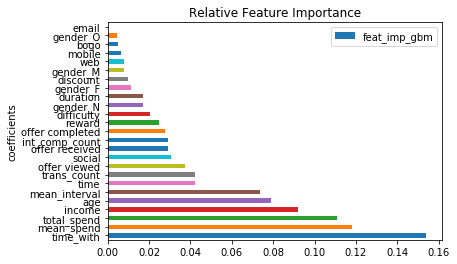

In [51]:
# Random Forest Classifier Classifier feature importance
fi_gbm = clf_gb.feature_importances_

feat_imp = pd.DataFrame()
X_var = list(off_rec_xy.drop('response', axis=1))

feat_imp = feat_imp.assign( coefficients = X_var, 
#              feat_imp_gb = fi_gb,
                feat_imp_gbm = fi_gbm,
            ).sort_values(by = 'feat_imp_gbm', ascending = False)


# Plot feature importance of best performing model 
ax = feat_imp.plot.barh(x='coefficients', y='feat_imp_gbm')
ax.set(title= 'Relative Feature Importance')

fig.show()

In [52]:
# predict probabilities of x
prob_array = clf_gb.predict_proba(X)
print('AUC Score = {}'.format(roc_auc_score(y, prob_array[:, 1])))

off_rec_prob = pfolio_sel.merge(off_rec_xy.merge(pd.DataFrame(prob_array), right_index=True, left_index=True), right_index = True, left_index=True)

AUC Score = 0.8388440666126801


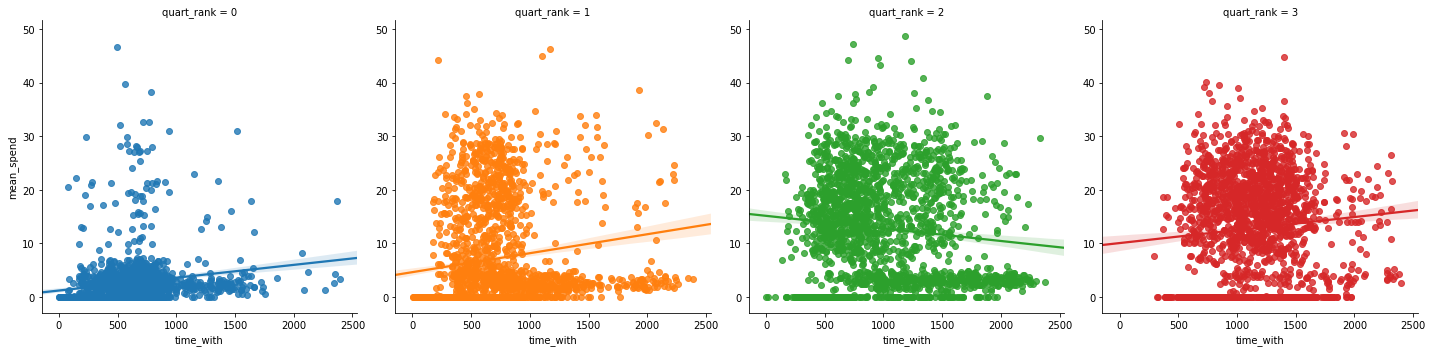

In [53]:
# 10_10_disc_2 example of difference in quartiles
prod1_eg= off_rec_prob[off_rec_prob['name'] == '10_10_disc_2']


# Top 6 feat by feat_imp
prod1_eg_feat = prod1_eg[['name', 'time_with', 'mean_spend', 'total_spend', 'income', 'mean_interval', 'age',0, 1, 'response']].sort_values(by = 1, ascending =False)
prod1_eg_feat['quart_rank']= pd.qcut(prod1_eg_feat[1], q = 4, labels = False) 
prod1_eg_feat['dec_rank']= pd.qcut(prod1_eg_feat[1], q = 10, labels = False) 
prod1_eg_feat = prod1_eg_feat[prod1_eg_feat['mean_spend'] < 50]

sns.lmplot(x = 'time_with', y ='mean_spend', data = prod1_eg_feat, hue = 'quart_rank', col = 'quart_rank')
#sns.lmplot(x = 'age', y ='income', data = prod1_test_feat, col = 'dec_rank', hue = 'dec_rank')

plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


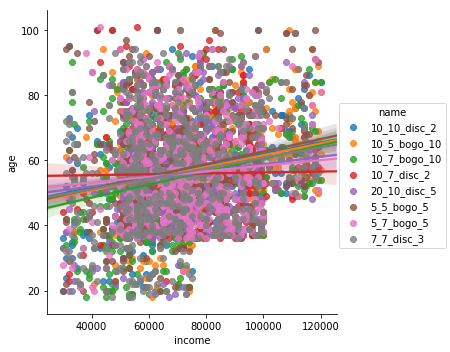

In [54]:
# Produce dataframe containing top decile of each product
top_dec = pd.DataFrame()

for t in target_vars:
    df = off_rec_prob[off_rec_prob['name'] == t]
    df['dec_rank']= pd.qcut(df[1], q = 10, labels = False) 
    df = df[df['mean_spend'] > 0]
    top_dec = top_dec.append(df[df['dec_rank'] == 9])  
    
# Plot top deciles on lmplot
sns.lmplot(x = 'income', y ='age', data = top_dec, hue = 'name')
plt.show()

In [55]:
# add control as overall population
control = off_rec_prob.copy()

control['dec_rank'] = np.nan
control['name'] = 'control'

top_dec = top_dec.append(control)

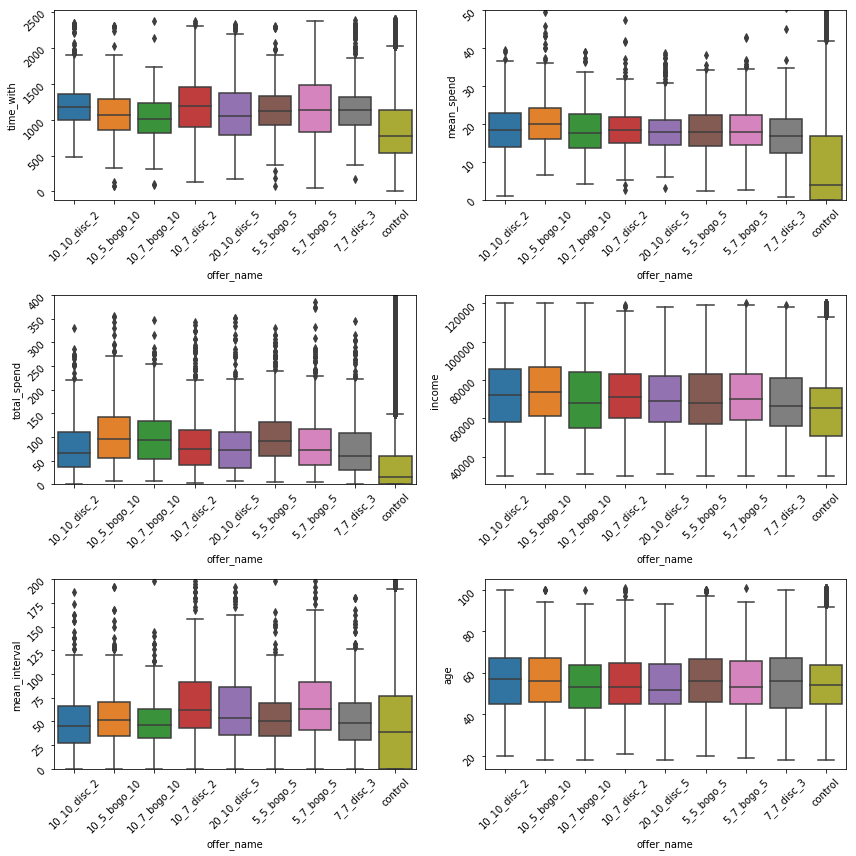

In [56]:
# Subplot of top 6 features from feature importance chart, for top decile of each product
top_dec = top_dec.rename(columns = {'name':'offer_name'})

fig, ax = plt.subplots(3,2, figsize = (12,12))


sns.boxplot(x = 'offer_name', y ='time_with', data = top_dec, ax= ax[0][0])
ax[0][0].tick_params(rotation=45)

sns.boxplot(x = 'offer_name', y ='mean_spend', data = top_dec, ax= ax[0][1])
ax[0][1].set_ylim(0,50)
ax[0][1].tick_params(rotation=45)

sns.boxplot(x = 'offer_name', y ='total_spend', data = top_dec, ax= ax[1][0])
ax[1][0].set_ylim(0,400)
ax[1][0].tick_params(rotation=45)

sns.boxplot(x = 'offer_name', y ='income', data = top_dec, ax= ax[1][1])
ax[1][1].tick_params(rotation=45)

sns.boxplot(x = 'offer_name', y ='mean_interval', data = top_dec, ax= ax[2][0])
ax[2][0].set_ylim(0,200)
ax[2][0].tick_params(rotation=45)

sns.boxplot(x = 'offer_name', y ='age', data = top_dec, ax= ax[2][1])
ax[2][1].tick_params(rotation=45)


fig.tight_layout()
plt.show()